# Generating composite images 

* **Products used:** `sen2_l2a_gcp`

## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one.

Some methods for generating composites include estimating the `median`, `mean`, `minimum`, or `maximum` pixel values in an image.

## Description
This notebook demonstrates how to generate a number of different composites from satellite images, and how to export them for further analysis in a GIS program on your computer.

1. Median composites
    * Generating single median composite
    * Generating multiple median composites based on length of time
    * Generating multiple median composites using `groupby`
2. Maximum index composites
3. Export result to GeoTiff
4. Download the file on your computer

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

In [1]:
import sys

sys.path.append("./utils/data_cube_utilities")

import numpy
import datacube
from time import time as time

from display_tools import rgb
from wdc_datahandling import cleaning_s2, cloud_coverage, export_to_GeoTiff
from wdc_bandindices import calculate_indices

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="Generating_composites")

## Create a query and load satellite data
To demonstrate how to compute image composites, we first need to load in a time series of satellite data for an area. 
We will use data from the Sentinel-2 satellite:

In [3]:
# Create a reusable query with coordinates indicated in EPSG:27700 CRS.
query = {
    "crs": "EPSG:27700",
    "x": (195670, 199780),
    "y": (193630, 196810),
    "time": ("2020-06", "2020-10"),
    "measurements": ["blue", "green", "red", "nir", "scl"],
    "output_crs": "EPSG:27700",
    "resolution": (-10, 10),
    "dask_chunks": {"y": 2048, "x": 2048},
}

start_load = time()

# Load available data from Sentinel-2 using the query dictionary
dataset = dc.load(product="sen2_l2a_gcp", **query)

end_load = time()

print(
    "Took "
    + str(round(end_load - start_load, 2))
    + " seconds to request "
    + str(len(dataset.time) * len(dataset.keys()))
    + " images from WDC for the specified extent/period."
)

Took 0.27 seconds to request 460 images from WDC for the specified extent/period.


## Clean the Sentinel-2 data

The indexed Sentinel-2 data are provided with  `scl` cloud mask in a separate layer and a scaling factor of 10,000. 

In the next cell, we clean the Sentinel-2 data (i.e., cloud masking and reflectance normalisation) using a custom library

In [4]:
# Let's clean the Sentinel-2 dataset (i.e., cloud masking and reflectance normalisation)
dataset_clean = cleaning_s2(dataset)

Cleaning Sentinel-2 images...
(Applying new Copernicus offset after 24 Jan 2022.)


## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for all the timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

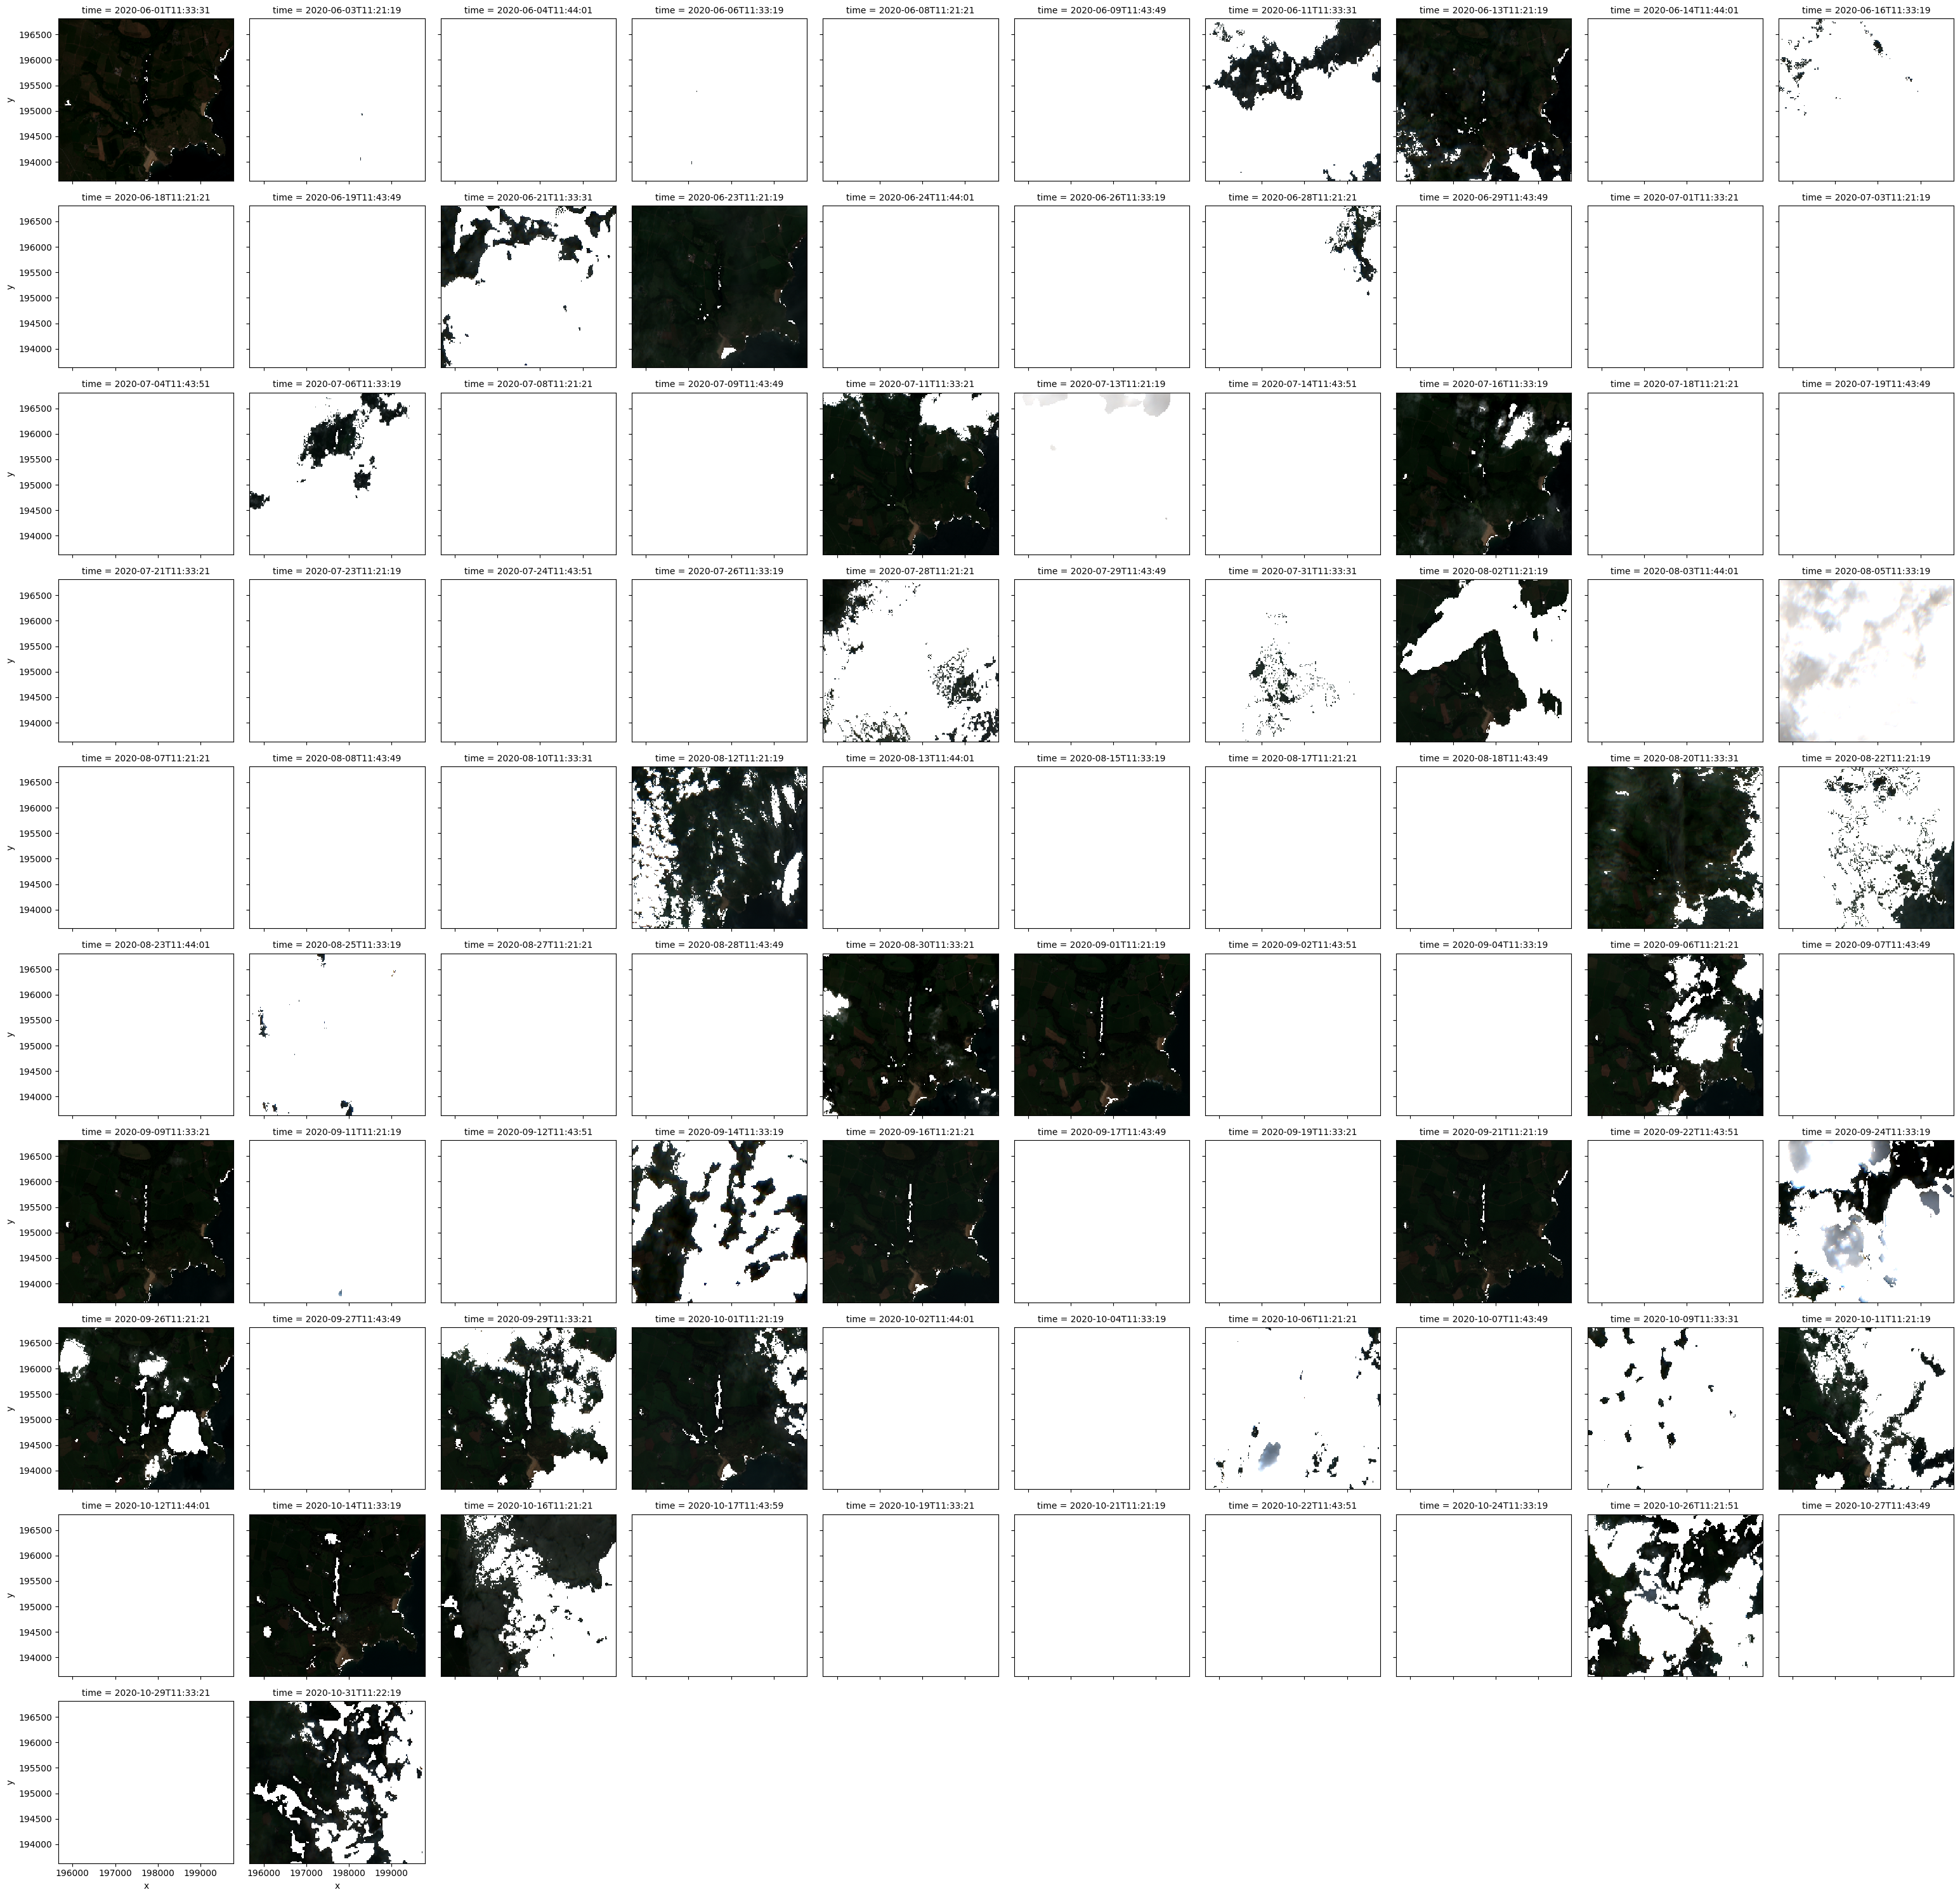

In [6]:
# Generate RGB plots at each timestep
rgb(dataset_clean, col="time", col_wrap=10, robust=True)

## Median composites

One of the key reasons for generating a composite is to replace pixels classified as clouds with realistic values from the available data. 
This results in an image that doesn't contain any clouds.

In the Open Data Cube environment, calculating statistics (i.e., composites) can easily be done by applying the statistical method (e.g., `max`, `min`, `mean`, `median`, `sum`, etc.) directly to the `xarray.DataArray` or `xarray.Dataset`.

In the case of a median composite, each pixel is selected to have the median (or middle) value out of all possible values.

> **Note:** Mean composites involve taking the average value for each pixel, rather than the middle value as is done for a median composite. Unlike the median, the mean composite can contain pixel values that were not part of the original dataset.
Care should be taken when interpreting these images, as extreme values (such as unmasked cloud) can strongly affect the mean.


### Generating a single median composite from all data

To generate a single median composite, we use the `xarray.median` method, specifying `'time'` as the dimension to compute the median over.

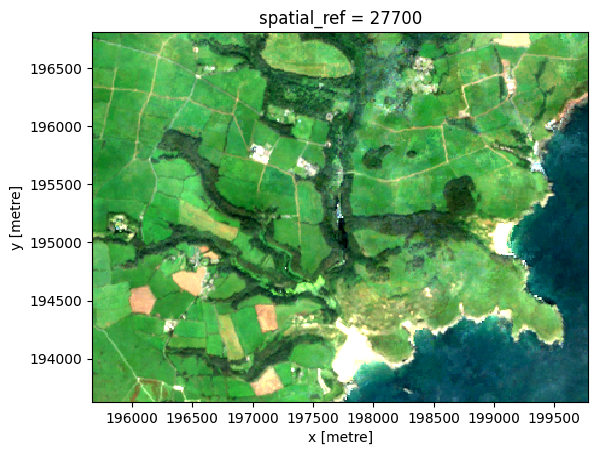

In [7]:
# Compute a single median from all data
dataset_median = dataset_clean.median("time", skipna=True)

# View the resulting median
rgb(dataset_median, robust=True)

### Generating multiple median composites based on length of time
Rather than using all the data to generate a single median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate medians for each of these.
Some resampling options are:
* `'nD'` - number of days (e.g. `'7D'` for seven days)
* `'nM'` - number of months (e.g. `'2M'` for two months)
* `'nY'` - number of years (e.g. `'1Y'` for 1 year)

If the area is particularly cloudy during one of the time-spans, there may still be masked pixels that appear in the median.
This will be true if that pixel is always masked.

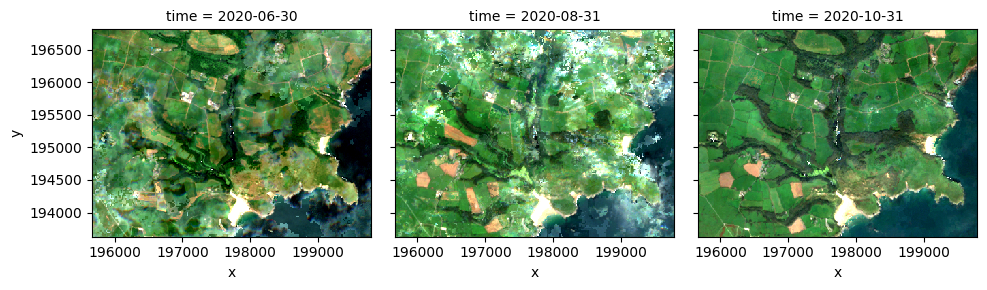

In [8]:
# Generate a median by binning data into two-monthly time-spans
dataset_resampled_median = dataset_clean.resample(time="2M").median("time", skipna=True)

# View the resulting medians
rgb(dataset_resampled_median, index=[0, 1, 2])

### Group By
Similar to resample, grouping works by looking at part of the date, but ignoring other parts. For instance, `'time.month'` would group together all January data together, no matter what year it is from.

Some examples are:
 * `'time.day'` - groups by the day of the month (1-31)
 * `'time.dayofyear'` - groups by the day of the year (1-365)
 * `'time.week'` - groups by week (1-52) 
 * `'time.month'` - groups by the month (1-12)
 * `'time.season'` - groups into 3-month seasons:
     - `'DJF'` December, Jaunary, February
     - `'MAM'` March, April, May
     - `'JJA'` June, July, August
     - `'SON'` September, October, November
 * `'time.year'` - groups by the year

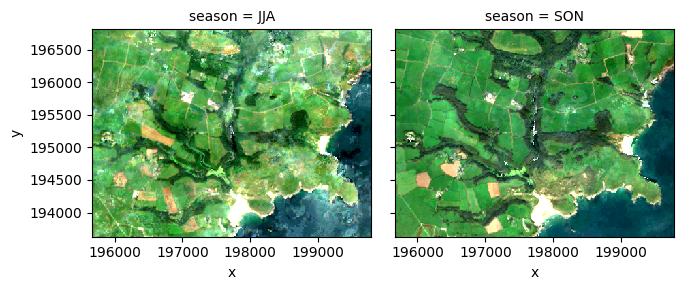

In [9]:
# Generate a median by binning data into three-monthly time-spans
ds_groupby_season = dataset_clean.groupby("time.season").median()

# View the resulting medians
rgb(ds_groupby_season, col="season")

## Maximum index composite

Maximum and minimum composites can be useful for identifying extreme behaviour in a collection of satellite images.
For example, calculating the maximum composite for NDVI index can help identify areas that are vegetated during, at least, a part of the year.
To demonstrate this, we start by calculating the normalised difference vegetation index (NDVI) for our data, which can then be used to generate the maximum composites.


In [10]:
# Start by calculating NDVI
dataset_NDVI = calculate_indices(
    dataset_clean, index="NDVI", platform="SENTINEL_2", quiet=True
)
dataset_NDVI

<xarray.Dataset> Size: 240MB
Dimensions:      (time: 92, y: 318, x: 411)
Coordinates:
  * time         (time) datetime64[ns] 736B 2020-06-01T11:33:31 ... 2020-10-3...
  * y            (y) float64 3kB 1.968e+05 1.968e+05 ... 1.936e+05 1.936e+05
  * x            (x) float64 3kB 1.957e+05 1.957e+05 ... 1.998e+05 1.998e+05
    spatial_ref  int32 4B 27700
Data variables:
    blue         (time, y, x) float32 48MB dask.array<chunksize=(1, 318, 411), meta=np.ndarray>
    green        (time, y, x) float32 48MB dask.array<chunksize=(1, 318, 411), meta=np.ndarray>
    red          (time, y, x) float32 48MB dask.array<chunksize=(1, 318, 411), meta=np.ndarray>
    nir          (time, y, x) float32 48MB dask.array<chunksize=(1, 318, 411), meta=np.ndarray>
    NDVI         (time, y, x) float32 48MB dask.array<chunksize=(1, 318, 411), meta=np.ndarray>


To generate a single maximum composite, we use the `xarray.max` method, specifying `'time'` as the dimension to compute the maximum over.

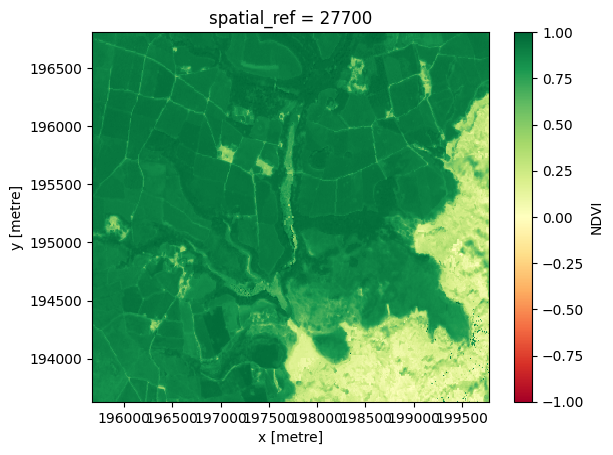

In [11]:
# Compute the maximum composite
ndvi_max = dataset_NDVI.NDVI.max("time")

# View the resulting composite
ndvi_max.plot(vmin=-1, vmax=1, cmap="RdYlGn");

> Note: By default, the statistic method skips missing values. To consider missing data, add the following paramater: `skipna=False`. More information on the statistic methods and their arguments is available in the [xarray official documentation](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.max.html).

## Export result to GeoTiff

Sometimes, you will want to analyse satellite imagery in a GIS program, such as QGIS.
The `export_to_GeoTiff()` command from the `WDC` library allows `xarray.DataArray` to be exported to GeoTiff, a commonly used file format for geospatial data.
> **Note**: the saved file will appear in the same directory as this notebook, and it can be downloaded from here for later use.

In [12]:
# Set a file
filename = "s2_2020-06_2020-10_ndvi_max.tiff"

export_to_GeoTiff(ndvi_max, filename=filename)

Array exported to s2_2020-06_2020-10_ndvi_max.tiff


## Download the file on your computer

To download the GeoTiff on your computer, go in the directory browser, select the `s2_2020-06_2020-10_ndvi_max.tiff` file, and click-right and select `Download`.